# EXP-01
----------
Policy mining based on complex network approach.

### Import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import igraph as ig
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit
from apriori_python import apriori
from auxiliar_funcs import *

### Load data

#### Auxiliar

In [2]:
def get_user_res(dataf, attr_list, user_):
    dict_temp = {}
    for i, j in enumerate(dataf[attr_list].drop_duplicates().values):
        if user_:
            idx = str(i) + "101"
        else:
            idx = str(i) + "202"
        dict_temp[int(idx)] = list(j)
    return dict_temp

def add_col(dataf, dict_, attr_list, name_col):
    list_users = []  # List to save users
    key_list = list(dict_.keys())
    val_list = list(dict_.values())

    for item in dataf[attr_list].values:
        if list(item) in val_list:
            idx = val_list.index(list(item))
            list_users.append(key_list[idx])
        else:
            list_users.append(11111111)

    dataf[name_col] = list_users
    return dataf

#### Load data


In [2]:
# Load data
url_file = '../00-Data/cav_policies.csv'
cav_data = pd.read_csv(url_file)

# Get a smaller sample: 15K positive and 15k negative.
# cav_data = cav_data.groupby('result').sample(n=15000)
print("Columns: ", cav_data.columns)
print("Lenght: ", len(cav_data)); print()

user_attr = ['control', 'monitoring', 'fallback', 'weather', 'visibility', 
        'traffic_congestion']
#user_attr = ['control', 'monitoring', 'fallback']
rsrc_attr = ['driving_task_loa', 'vehicle_loa', 'region_loa']
cav_data = cav_data[user_attr + rsrc_attr + ['result']]

# Change string values to numerical
mapping = {'system': 10101, 'human': 10201, 'human and system': 10301} # Control
cav_data.control = cav_data.control.replace(mapping)

mapping = {'system': 20102, 'human': 20202} # monitoring
cav_data.monitoring = cav_data.monitoring.replace(mapping)

mapping = {'system': 30103, 'human': 30203} # fallbacj
cav_data.fallback = cav_data.fallback.replace(mapping)

mapping = {0: 40004, 1: 40104, 2: 40204, 3: 40304, 4: 40404, 5: 40504}
cav_data.driving_task_loa = cav_data.driving_task_loa.replace(mapping)

mapping = {0: 50005, 1: 50105, 2: 50205, 3: 50305, 4: 50405, 5: 50505}
cav_data.vehicle_loa = cav_data.vehicle_loa.replace(mapping)

mapping = {0: 60006, 1: 60106, 2: 60206, 3: 60306, 4: 60406, 5: 60506}
cav_data.region_loa = cav_data.region_loa.replace(mapping)


print("# User attr:", len(user_attr))
print("# Rsrc attr:", len(rsrc_attr)); print()

# Data statictics:
n_users = len(cav_data[user_attr].drop_duplicates())
n_rscrc = len(cav_data[rsrc_attr].drop_duplicates())
print("|U| =", n_users)
print("|R| =", n_rscrc); print()

# Add user and resource id columns
user_dict = get_user_res(cav_data, user_attr, True)
rsrc_dict = get_user_res(cav_data, rsrc_attr, False)
cav_data = add_col(cav_data, user_dict, user_attr, "USRID")
cav_data = add_col(cav_data, rsrc_dict, rsrc_attr, "RESID")

# Accepted and rejected requests
cav_pos = cav_data[cav_data.result == 'approved']
cav_neg = cav_data[cav_data.result == 'rejected']
print("|L+| =", len(cav_pos), "{:.2f}%".format((len(cav_pos) 
        / len(cav_data) ) * 100))
print("|L-| =", len(cav_neg), "{:.2f}%".format((len(cav_neg) 
        / len(cav_data) ) * 100))

Columns:  Index(['driving_task_type', 'control', 'monitoring', 'fallback', 'weather',
       'visibility', 'traffic_congestion', 'environmental_weighted_average',
       'driving_task_loa', 'vehicle_loa', 'region_loa', 'result'],
      dtype='object')
Lenght:  239580

# User attr: 6
# Rsrc attr: 3

|U| = 6655
|R| = 216



In [114]:
# Save modified dataframe
# cav_data.to_csv('output-files/df-cav-data.csv')
print("Done!")

Done!


In [ ]:
# Cross validation
k = 10
test_size = 0.2
kfold = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=1)

data_partition = kfold.split(cav_data, cav_data.result)
data_curpus = [] # A list to storage the k folds

for train_data, test_data in data_partition:
    X_train, X_test = cav_data.iloc[train_data], cav_data.iloc[test_data]
    data_curpus.append([X_train, X_test])

print("Done!")  
print(" - k =", k)
print(" - Train-Test size: ", len(data_curpus[0][0]), "(", (1-test_size)*100, ") \t", len(data_curpus[0][1]), "(", test_size*100, ")")

Done!
 - k = 10
 - Train-Test size:  191664 ( 80.0 ) 	 47916 ( 20.0 )


## Data preprocessing

#### Task 1, 2 and 3

In [ ]:
id_kfold = 1

cav_train, cav_test = data_curpus[id_kfold][0], data_curpus[id_kfold][1]
print("# Train access request =", len(cav_train), "{:.2f}%".format(
    len(cav_train)/(len(cav_train)+len(cav_test))*100))
print("# Train access request =", len(cav_test), "{:.2f}%".format(
    len(cav_train)/(len(cav_train)+len(cav_test))*100))
print("Total =", len(cav_train)+len(cav_test)); print()

#### **** SELECT FUNCTIONAL ATTRIBUTES **** ####
cav_train = cav_train[user_attr + rsrc_attr + ['USRID', 'RESID', 'result']]
cav_test = cav_test[user_attr + rsrc_attr + ['USRID', 'RESID', 'result']]

##### ***** Task 1: Null and uknwokn values ***** #####
print("TASK 1: Done!"); print() # NA


##### ***** TASK 2: convert continuous values to categorical values ***** #####
print("TASK 2: Done!"); print() # NA 

##### ***** TASK 3: Drop duplicates access requests ***** #####
print("TASK 3: Drop duplicates access requests")

positive_cav_train = cav_train[cav_train.result=='approved']
positive_cav_test = cav_test[cav_test.result=='approved']
negative_cav_train = cav_train[cav_train.result=='rejected']
negative_cav_test = cav_test[cav_test.result=='rejected']


print(" -TRAIN DATA: Removing", 
    len(positive_cav_train.drop_duplicates()) - 
    len(positive_cav_train), "positive access requests")
print(" -TRAIN DATA: Removing", 
    len(negative_cav_train.drop_duplicates()) - 
    len(negative_cav_train), "negative access requests")
print(" -TEST DATA: Removing", 
    len(positive_cav_test.drop_duplicates()) - 
    len(positive_cav_test), "positive access requests")
print(" -TEST DATA: Removing", 
    len(negative_cav_test.drop_duplicates()) - 
    len(negative_cav_test), "negative access requests")

# Train access request = 191664 80.00%
# Train access request = 47916 80.00%
Total = 239580

TASK 1: Done!

TASK 2: Done!

TASK 3: Drop duplicates access requests
 -TRAIN DATA: Removing 0 positive access requests
 -TRAIN DATA: Removing 0 negative access requests
 -TEST DATA: Removing 0 positive access requests
 -TEST DATA: Removing 0 negative access requests


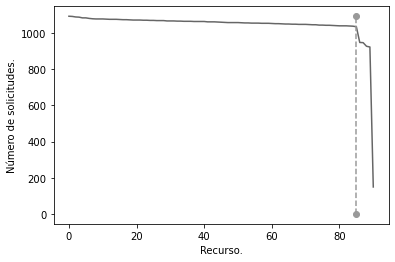

In [5]:
###### Tarea 4: recursos más frecuentes
res_to_freq = (positive_cav_train.RESID.value_counts()).to_dict()
res_to_freq_lists = res_to_freq.items()
x_list, y_list = zip(*res_to_freq_lists)
# plt.figure(figsize=(20,10))
plt.plot(y_list, color='0.40', linestyle='-')
# plt.plot(141,8, marker="o", color="red")
plt.ylabel('Número de solicitudes.')
plt.xlabel('Recurso.')
n_corte_recursos = 85
x1, y1 = [n_corte_recursos, n_corte_recursos] , [0, max(y_list)]
plt.plot(x1, y1, marker = 'o', linestyle='--', color="0.6")
#plt.text(n_corte_recursos+100, 5, '{}'.format(n_corte_recursos) , ha='left', va= 'top')
plt.savefig('frec-res-amz-corte.pdf')
plt.show()



In [6]:
len(positive_cav_train.RESID.drop_duplicates())

91

In [5]:
# Filter resources
n1 = 0
n2 = 84
top_list = positive_cav_train.RESID.value_counts()[:len(positive_cav_train.RESID.drop_duplicates())].index.tolist()
# Filter the interval between n1 and n2
top_list = top_list[n1:n2+1]
print('#Filtered resources:', len(top_list))

#Filtered resources: 85


In [8]:
negative_cav_train = cav_train[cav_train.result=='rejected']
len(negative_cav_train)

96484

In [6]:
boolean_series = positive_cav_train.RESID.isin(top_list)
positive_cav_train = positive_cav_train[boolean_series]
#bolean_series = negative_cav_train.RESID.isin(top_list)
#negative_cav_train = negative_cav_train[bolean_series]
print("Hecho!")

Hecho!


In [10]:
len(negative_cav_train)

96484

## Network modelling

### TASK 1: Bipartite Access Requests Network

In [7]:
edges = []
for usr_idx, rsr_idx in positive_cav_train[['USRID', 'RESID']].values:
    edges.append((int(usr_idx), int(rsr_idx)))
gb = nx.Graph()
gb.add_edges_from(edges)

gb = ig.Graph.from_networkx(gb)
gb.vs["name"] = gb.vs["_nx_name"]
del gb.vs["_nx_name"]

# Identify user and resources NODES
list_temp = list(positive_cav_train.USRID)
list_type = []
for node in gb.vs():
    if node['name'] in list_temp:
        list_type.append(0)
    else:
        list_type.append(1)

gb.vs['typen'] = list_type
print(gb.summary())
print("User nodes =", len(gb.vs.select(typen=0)))
print("Rsrc nodes =", len(gb.vs.select(typen=1)))
print("Is bipartite? ", gb.is_bipartite())

# ig.write(gb, "output-files/bi-cav.gml")

IGRAPH UN-- 5388 90251 -- 
+ attr: name (v), typen (v)
User nodes = 5303
Rsrc nodes = 85
Is bipartite?  True


### TASK 2: User Network

#### Auxiliar

In [12]:
def edge_weight(node_u, node_v):
    """Return the edge weight between two nodes."""
    neig_u = set(node_u.neighbors())
    neig_v = set(node_v.neighbors())
    inter_neig_uv = neig_u.intersection(neig_v)

    return (len(inter_neig_uv) / len(neig_u)) * (len(inter_neig_uv) / len(neig_v))

def graph_projectionB(bipartite_graph):
    G = nx.Graph()        
    for r_node in bipartite_graph.vs.select(typen=1): # Every resource
        neighborhood = r_node.neighbors()
        for u_node in neighborhood:
            for v_node in neighborhood:
                if u_node["name"] != v_node["name"]:
                    if G.has_edge(u_node["name"], v_node["name"]):
                        pass
                    else:
                        G.add_edge(u_node["name"], v_node["name"], weight=edge_weight(u_node, v_node) )                                 
    return G

def graph_projectionC(bipartite_graph):
    G = nx.Graph()        
    for r_node in bipartite_graph.vs.select(typen=1): # Every resource
        neighborhood = r_node.neighbors()
        wei_local = 1 / len(neighborhood)
        for i in range(len(neighborhood)): # Load every list
            for j in range(i+1, len(neighborhood)):
                if G.has_edge(neighborhood[i]["name"], neighborhood[j]["name"]):
                    G[neighborhood[i]["name"]][neighborhood[j]["name"]]['weight'] += wei_local
                else:
                    G.add_edge(neighborhood[i]["name"], neighborhood[j]["name"], weight=wei_local)                            
    return G

def partition_quality(G, partition):
    """Returns the coverage and performance of a partition of G.

    The *coverage* of a partition is the ratio of the number of
    intra-community edges to the total number of edges in the graph.

    The *performance* of a partition is the number of
    intra-community edges plus inter-community non-edges divided by the total
    number of potential edges.

    This algorithm has complexity $O(C^2 + L)$ where C is the number of communities and L is the number of links.

    Parameters
    ----------
    G : igraph graph

    partition : sequence
        Partition of the nodes of `G`, represented as a sequence of
        sets of nodes (blocks). Each block of the partition represents a
        community.

    Returns
    -------
    (float, float)
        The (coverage, performance) tuple of the partition, as defined above.

    Raises
    ------
    NetworkXError
        If `partition` is not a valid partition of the nodes of `G`.

    Notes
    -----
    If `G` is a multigraph;
        - for coverage, the multiplicity of edges is counted
        - for performance, the result is -1 (total number of possible edges is not defined)

    References
    ----------
    .. [1] Santo Fortunato.
           "Community Detection in Graphs".
           *Physical Reports*, Volume 486, Issue 3--5 pp. 75--174
           <https://arxiv.org/abs/0906.0612>
    """

    node_community = {}
    for i, community in enumerate(partition.membership):
        #for node in community:
        node_community[i] = community

    # Iterate over the communities, quadratic, to calculate 
    # `possible_inter_community_edges`
    possible_inter_community_edges = sum(
        p1 * p2 for p1, p2 in combinations(partition.sizes(), 2)
    )
    # Compute the number of edges in the complete graph -- `n` nodes,
    # directed or undirected, depending on `G`
    n = G.vcount()
    total_pairs = n * (n - 1)
    total_pairs //= 2

    intra_community_edges = 0
    inter_community_non_edges = possible_inter_community_edges

    # Iterate over the links to count `intra_community_edges` and `inter_community_non_edges`
    for e in G.es():
        if node_community[e.tuple[0]] == node_community[e.tuple[1]]:
            intra_community_edges += 1
        else:
            inter_community_non_edges -= 1

    coverage = intra_community_edges / G.ecount()
    performance = (intra_community_edges + inter_community_non_edges) / total_pairs

    return coverage, performance

#### Main

In [8]:
g_proj_B = graph_projectionB(gb) # Bipartite projection
print(nx.info(g_proj_B)) # Networkx network

# Convert to igraph object graph
g_proj_B = ig.Graph.from_networkx(g_proj_B)
g_proj_B.vs["name"] = g_proj_B.vs["_nx_name"]
del g_proj_B.vs["_nx_name"]
print(ig.summary(g_proj_B)) # igraph network

Name: 
Type: Graph
Number of nodes: 5303
Number of edges: 3512510
Average degree: 1324.7256
IGRAPH UNW- 5303 3512510 -- 
+ attr: name (v), weight (e)
None


In [65]:
dict_edge_weight = {}
for i in sorted(set(g_proj_B.es()["weight"])):    
    dict_edge_weight[i] = len(g_proj_B.es.select(weight_eq=i))
print(dict_edge_weight)

{0.04000000000000001: 188, 0.041666666666666664: 282, 0.047619047619047616: 25, 0.04938271604938271: 1, 0.05: 368, 0.05555555555555555: 59, 0.0625: 85, 0.06666666666666667: 35, 0.08333333333333333: 12, 0.09999999999999999: 23, 0.10227272727272727: 16, 0.1111111111111111: 29, 0.11160714285714286: 1, 0.11249999999999999: 58, 0.11574074074074076: 1, 0.125: 50, 0.1282051282051282: 2, 0.13020833333333334: 1, 0.13333333333333333: 2856, 0.140625: 17, 0.14285714285714285: 1407, 0.1488095238095238: 1, 0.15000000000000002: 1, 0.15126050420168066: 1, 0.16000000000000003: 1573, 0.1607142857142857: 2, 0.1616161616161616: 113, 0.16289592760181: 2, 0.16666666666666666: 2412, 0.17142857142857143: 2, 0.17307692307692307: 1, 0.17647058823529413: 8, 0.17777777777777778: 245, 0.18181818181818182: 224, 0.18367346938775508: 1, 0.1840909090909091: 1, 0.18461538461538463: 1, 0.1875: 5, 0.19047619047619047: 179, 0.19140625: 4, 0.19215686274509802: 8, 0.19444444444444445: 4, 0.19753086419753085: 100, 0.19780219

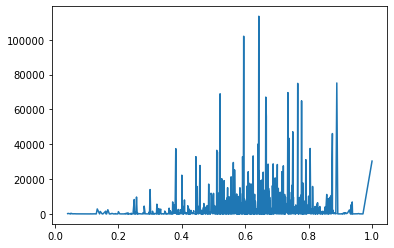

In [69]:
plt.plot(dict_edge_weight.keys(), dict_edge_weight.values())

In [77]:
test = g_proj_B.copy()
test.summary()

'IGRAPH UNW- 5303 3512559 -- \n+ attr: name (v), weight (e)'

In [2]:
g_proj_B = ig.read("output-files/proj-cav-subclustering.gml")

In [4]:
g_proj_B.delete_edges(g_proj_B.es.select(weight_le=1))
g_proj_B.summary()

'IGRAPH UNW- 5303 0 -- \n+ attr: cluster (v), control (v), fallback (v), id (v), monitoring (v), name (v), ncluster (v), trafficcongestion (v), visibility (v), weather (v), weight (e)'

In [5]:
g_proj_B.write("Azuquitar.gml")

### TASK 3: Network Analysis

P1: n = |V|, m = |E| commonly in the order of thousands or millions.
Vértices:  5303
Aristas:  3512510

P2: low average degree *k* << n.
Avarage Degree (k): 1324.7256  << 5303

P3: low density d << 1.
Density: 0.2499  << 5303

P4: low average path length L << n.
Average Path Length : 1.0000  << 5303

P5: hight average cluster coefficient 1/n << *C* < 1.
0.0002 << Average Path Length : 1.0000  < 1

P6: Scale-free distribution p(k) = ∼k^{−α}.


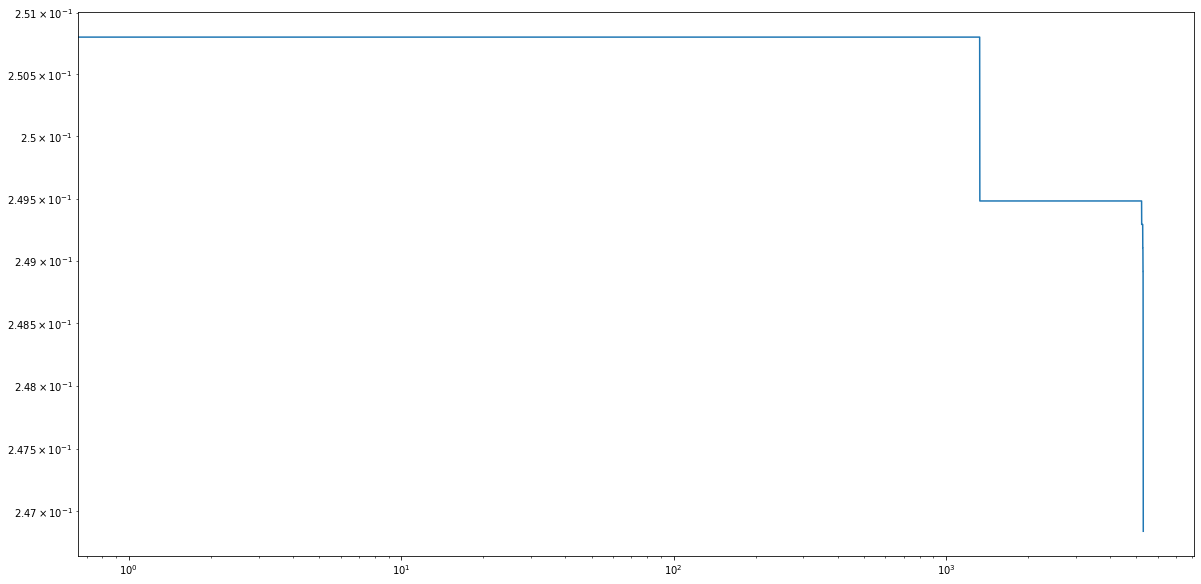

In [ ]:
##### P1: n = |V|, m = |E| commonly in the order of thousands or millions. #####
n = g_proj_B.vcount()
m = g_proj_B.ecount()
print("P1: n = |V|, m = |E| commonly in the order of thousands or millions.")
print("Vértices: ", n)
print("Aristas: ", m)
print()

##### P2: low average degree *k* << n. #####
print("P2: low average degree *k* << n.")
print("Avarage Degree (k): {:.4f}".format(ig.mean(g_proj_B.degree())), " <<", n)
print()

##### P3: low density d << 1. #####
print("P3: low density d << 1.")
d = g_proj_B.density()
print("Density: {:.4f}".format(d), " <<",n)
print()

##### P4: low average path length L << n. #####
print("P4: low average path length L << n.")
L = g_proj_B.average_path_length()
print("Average Path Length :", "{:.4f}".format(L), " <<", n)
print()

##### P5: hight average cluster coefficient 1/n << *C* < 1. #####
print("P5: hight average cluster coefficient 1/n << *C* < 1.")
cc = g_proj_B.transitivity_avglocal_undirected()
print("{:.4f}".format(1/n),"<<","Average Path Length :", 
    "{:.4f}".format(cc), " <", 1)
print()

##### P6: Scale-free distribution p(k) = ∼k−α. #####
print("P6: Scale-free distribution p(k) = ∼k^{−α}.")
distri_grados = [i/g_proj_B.vcount() for i in g_proj_B.degree()]
plt.figure(figsize=(20,10))
plt.plot(sorted(distri_grados,reverse=True))
#x1, y1 = [100, 700], [0.13, 0.015]
#x2, y2 = [1, 231], [3, 2]
#plt.plot(x1, y1, marker = 'o')
plt.yscale("log")
plt.xscale("log")
plt.show()
print()

P6: Scale-free distribution p(k) = ∼k^{−α}.


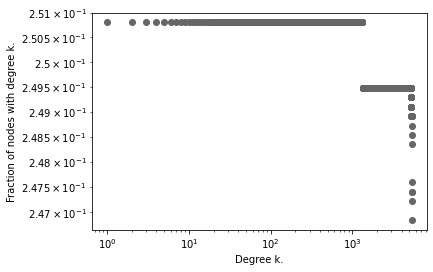

In [17]:
##### P6: Scale-free distribution p(k) = ∼k−α. #####
print("P6: Scale-free distribution p(k) = ∼k^{−α}.")
distri_grados = [i/g_proj_B.vcount() for i in g_proj_B.degree()]
#plt.figure(figsize=(20,15))
plt.plot(sorted(distri_grados,reverse=True),linestyle='', marker='o', color="0.4")

#x2, y2 = [1, 231], [3, 2]
# plt.plot(x1, y1, marker = 'o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Degree k.')
plt.ylabel('Fraction of nodes with degree k.')
plt.savefig('degree-distri-cav.pdf')
plt.show()

## Community Detection

### Auxiliar

In [9]:
def num_recursos(user_sets, grafo_bip):
    all_recursos = set()
    user_sets = [int(float(i)) for i in user_sets]
    for user in user_sets:
        #user_node = grafo_bip.vs.find(name=int(float(user)))
        #print(user)
        try:
            user_node = grafo_bip.vs.find(name=user)
        except:
            continue
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = set(vecinos_recurso)    
        all_recursos = all_recursos.union(vecinos_recurso)
    return list(all_recursos)            

def numero_registros2(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  len(list(dict_temp.keys()))
    return len(list(dict_temp.keys()))

def numero_registros3(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp


def numero_registros4(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == int(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp

def get_users_from_resource_comms(resource_id, community, data):
    """Retorna los usuarios de la comunidad que acceden al conjunto de recursos"""
    users_to_ret = []
    for res in resource_id:
        all_user_in_community = community.vs()["label"] # Extraer usuarios de comunidad
        ## all_user_in_community = [int(item) for item in all_user_in_community] # Convertimos a int
        all_user_in_community = set(all_user_in_community) # Covnertimos a conjunto
        solicitudes_en_data = data[data["RESID"]==res]["USRID"].to_list() # Todos los usuarios que acceden al recurso
        solicitudes_en_data = [str(item)+".0" for item in solicitudes_en_data]
        solicitudes_en_data = set(solicitudes_en_data)
        # print(all_user_in_community)
        # print(solicitudes_en_data)
        users_to_ret = users_to_ret + list(all_user_in_community.intersection(solicitudes_en_data)) # Intersección
    users_to_ret = list(set(users_to_ret))
    return users_to_ret

def remove_equal_rules(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    lrules = len(rules)
    for i in range(lrules):
        for j in range(i+1,lrules):
            if rules[i][0] == rules[j][1] and rules[i][1] == rules[j][0]:        
                to_remove.append(rules[i])

    #print(to_remove)
    return to_remove

def remove_equal_rules2(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    #print(rules)
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        #print(descri)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)

    # Quedarse con la de mayor tamaño
    max_id = 0
    to_ret = None
    for i in to_remove:        
        if len(i) > max_id:            
            max_id = len(i)
            to_ret = i

    return [to_ret]

def remove_equal_rules3(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    #print(rules)
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        #print(descri)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)

    # Quedarse con la de mayor tamaño
    max_id = 0
    to_ret = None
    for i in to_remove:        
        if len(i) < 3:            
            #max_id = len(i)
            to_ret = i

    return [to_ret]

def remove_equal_rules4(rules, recurso_atr, reglas_ant):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    #print(rules)
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        #print(descri)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)

    # Quedarse con la de mayor tamaño
    used_idx = []
    encontrado = False
    while not encontrado:        
        idx_rand = random.randint(0, len(to_remove)-1)
        if idx_rand in used_idx:
            continue
        else:
            used_idx.append(idx_rand)
            temp_to_ret = to_remove[idx_rand]
            temp_rule = recurso_atr + temp_to_ret
            if temp_rule in reglas_ant:
                continue
            else:
                to_ret = temp_to_ret

    return [to_ret]

# Function to check if a value appear in column
def get_attr_name(value, df_):
    """ Return name of the column of the value."""
    cols = df_.columns  
    if value == 10:
            # Buscar el atributo maximo
        max_val = 0
        attr_  = None
        for i in cols:        
            t = len(df_[df_[i]==10])            
            if t > max_val:
                max_val = t
                attr_ = i
        return attr_
    else:
        for i in range(len(cols)):        
            if len(df_[df_[cols[i]]==value]) > 0:
                return df_.columns[i]

def get_attr_val_in_users(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr+["USRID"]].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_users_2(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res_2(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi


def podado_recursos(recursos, subgrafo, umbral):
    """Realiza el podado de los recursos que casi no acceden"""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) > umbral:
            to_ret[i] = us_temp
    return to_ret

def recurso_significativo(recursos, subgrafo, umbral):
    """Retorna el recurso significativo. 'None' si no hay."""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) >= umbral:
            return to_ret[i]
    return None

def extraer_recursos_similares(recursos, data_, umbral):
    """Retorna registros similares como nuevos registros"""

    for atr in rsrc_attr: # Se reccorre los atributos
        for r1 in recursos: # Se recorre los recursos
            for atr2 in rsrc_attr:
                if atr != atr2: # Se cambian los recursos
                    print()


def get_apriori_final(usuarios, recursos, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in usuarios] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    res_convert = [float(n) for n in recursos] # Convertimos a float
    attr_user_ = attr_user_[attr_user_["RESID"].isin(res_convert)].drop_duplicates() # Seleccionamos recursos
    attr_user__ = attr_user_[user_attr+rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+rsrc_attr]
    # print(attr_user_)
    init_Sup = 0.5
    init_Conf = 0.8
    rules = []
    while len(rules) == 0:
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def agregar_diccionario(diccionario, recurso, tupla_datos):
    if recurso in diccionario:
        diccionario[recurso].append(tupla_datos)
    else:
        diccionario[recurso] = [tupla_datos]

def agregar_usuario_com(diccio, com_id, usuario):
    if com_id in diccio:
        if not usuario in diccio[com_id]:
            diccio[com_id].append(usuario)
    else:
        
        diccio[com_id] = [usuario]


### TASK 1: Community Detection

In [9]:
partition = g_proj_B.community_multilevel(weights=g_proj_B.es()["weight"])
print("Modularity: %.4f" % partition.modularity)

# Agregar atributos al grafo bipartito
for attr in user_attr:    
    list_temp = []
    for node in g_proj_B.vs():                
        id_name = float(node["name"])
        temp = pd.DataFrame(positive_cav_train[positive_cav_train.USRID==id_name])            
        temp = temp[attr].drop_duplicates()            
        temp = temp.values[0]
        list_temp.append(temp)            
    g_proj_B.vs[attr] = list_temp

# Add cluster attribute to nodes
g_proj_B.vs["cluster"] = partition.membership
ig.write(g_proj_B, "output-files/proj-cav.gml")
print(g_proj_B.summary())

Modularity: 0.7500
IGRAPH UNW- 5303 3512510 -- 
+ attr: cluster (v), control (v), fallback (v), monitoring (v), name (v), traffic_congestion (v), visibility (v), weather (v), weight (e)


#### Sub-Communities

In [13]:
# Se obtienen las comunidades y sub-comunidades
g = g_proj_B

density_threshold = 0.5

n_coms = len(set(g.vs["cluster"]))
count_n_coms = 0 # Contador de número de comunidades detectadas
# Diccionario con las comunidades. Id de la comunidad como key y una lista 
# como value {01: [subgrafo, recursos_list]}
dict_total_coms = {} 

for idx_comm in range(n_coms): # Recorrer cada comunidad en la red
    subgraph_nodes = g.vs.select(cluster=idx_comm) # Sacamos los nodos con el cluster
    comm_subgraph = subgraph_nodes.subgraph() # Objeto de subgrafo

    # Verificar si la densidad es baja: Si es baja se puede clasificar
    if comm_subgraph.density() < density_threshold:

        # Se realiza nuevamente una partición
        new_partition = comm_subgraph.community_multilevel(
            weights =comm_subgraph.es["weight"] )        

        for sub_com in new_partition.subgraphs(): # Se recorre cada nueva sub comunidad
            # Usuarios en la comunidad
            user_set_comm = sub_com.vs()["name"]   
            # Recursos en la comunidad
            n_res = num_recursos(user_set_comm, gb)            
            dict_total_coms[str(count_n_coms)] = [sub_com, n_res]
            count_n_coms += 1
    else:
        user_set_comm = comm_subgraph.vs()["name"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, gb)            
        dict_total_coms[str(count_n_coms)] = [comm_subgraph, n_res]
        count_n_coms += 1

print("# de Comunidades: ", len(dict_total_coms))

# de Comunidades:  4


In [10]:
# Se obtienen las comunidades y sub-comunidades
g = g_proj_B

density_threshold = 0.5

n_coms = len(set(g.vs["cluster"]))
count_n_coms = 0 # Contador de número de comunidades detectadas
# Diccionario con las comunidades. Id de la comunidad como key y una lista 
# como value {01: [subgrafo, recursos_list]}
dict_total_coms = {} 

for idx_comm in range(n_coms): # Recorrer cada comunidad en la red
    subgraph_nodes = g.vs.select(cluster=idx_comm) # Sacamos los nodos con el cluster
    comm_subgraph = subgraph_nodes.subgraph() # Objeto de subgrafo
    
    # Se realiza nuevamente una partición
    new_partition = comm_subgraph.community_multilevel(
        weights =comm_subgraph.es["weight"] )        

    for sub_com in new_partition.subgraphs(): # Se recorre cada nueva sub comunidad
        # Usuarios en la comunidad
        user_set_comm = sub_com.vs()["name"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, gb)            
        dict_total_coms[str(count_n_coms)] = [sub_com, n_res]
        count_n_coms += 1
    """ else:
        user_set_comm = comm_subgraph.vs()["name"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, gb)            
        dict_total_coms[str(count_n_coms)] = [comm_subgraph, n_res]
        count_n_coms += 1 """

print("# de Comunidades: ", len(dict_total_coms))

# de Comunidades:  22


In [62]:
# Function to add new cluster id to the nodes
def add_new_cluster_id(dict_comms, user_network):
    """
    Function to add sub-cluster id to the user network nodes.
    """
    temp_list = []
    for node in user_network.vs():
        node_name = node["name"] # Name of the node        
        for i, j in dict_total_coms.items(): # Looping in the dict
            #print(node_name, j[0].vs().find(name_eq=int(node_name)))
            try:
                is_in = j[0].vs().find(name_eq=int(node_name))
                temp_list.append(i) # Add id cluster
            except:
                continue        

    user_network.vs()["n_cluster"] = temp_list
    return user_network


In [14]:
test = add_new_cluster_id(dict_total_coms, g)

In [34]:
ig.write(test, "output-files/proj-cav-subclustering.gml")

### TASK 2: Community classification

In [11]:
# Obtener el máximo valor de recursos en el total de comunidades
n_res_in_comms = [len(i[1]) for i in dict_total_coms.values()]
max_n_res = max(n_res_in_comms)
print("Comunidad con # mayor recursos", max_n_res)

# Umbrales para la clasificación de comunidades
big_threshold = int(0.75 * max_n_res)
med_threshold = int(0.50 * max_n_res)
print("Big Threshold: ", big_threshold, " \t\t Med Threshold", med_threshold)

Comunidad con # mayor recursos 36
Big Threshold:  27  		 Med Threshold 18


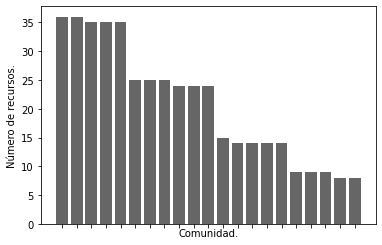

In [16]:
plt.bar(dict_total_coms.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('output-files/n_recursos_por_comunidad_amz.pdf')

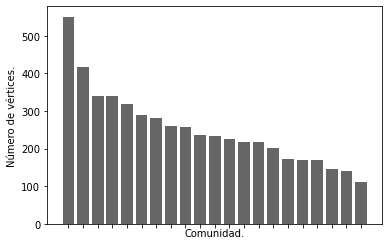

In [17]:
lista_tamano_coms = []
for i in dict_total_coms:
    lista_tamano_coms.append(dict_total_coms[i][0].vcount())
    #print(dict_total_coms[i][0].vcount())
len(lista_tamano_coms)

# plt.figure(figsize=(20,15))
plt.bar(dict_total_coms.keys(), sorted(lista_tamano_coms, reverse=True), color='0.40')
plt.ylabel('Número de vértices.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('output-files/n_vertices_por_comunidad_amz.pdf')

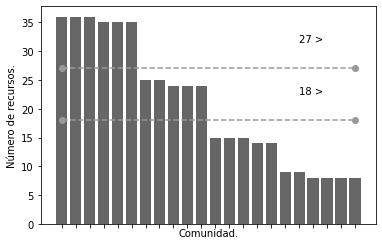

In [12]:
# plt.figure(figsize=(20,15))
plt.bar(dict_total_coms.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
x, y = [0, len(n_res_in_comms)-1] , [big_threshold, big_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, big_threshold+6, '{} >'.format(big_threshold) , ha='left', va= 'top')
x, y = [0, len(n_res_in_comms)-1] , [med_threshold, med_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, med_threshold+6, '{} >'.format(med_threshold) , ha='left', va= 'top')
plt.tick_params(labelbottom=False)
#plt.savefig('output-files/n_recursos_por_comunidad_amz-corte.pdf')

In [13]:
big_comms = [] # Almacenar las comunidades grandes
med_comms = [] # Almacenar las comunidades medianas
sma_comms = [] # Almacenar las comunidades pequeñas

for idx_com, com in enumerate(dict_total_coms.values()):
    if len(com[1]) > big_threshold: # Es comunidad grande
        big_comms.append([idx_com]+com)
    elif len(com[1]) > med_threshold: # Es comunidad mediana
        med_comms.append([idx_com]+com)
    else:
        sma_comms.append([idx_com]+com)

print("# Comunidades:",len(big_comms)+len(med_comms)+len(sma_comms), "==", len(dict_total_coms))
print("Big Comms:", len(big_comms))
print("Med Comms:", len(med_comms))
print("Sma Comms:", len(sma_comms))

# Comunidades: 22 == 22
Big Comms: 6
Med Comms: 5
Sma Comms: 11


## Rule Inference

### Auxiliar

In [16]:
def apriori_in_resources(data_):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0: # AND NOT rules in list_rules
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, data_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def apriori_in_resources_2(data_):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.5
    init_Conf = 0.7
    rules = []
    while len(rules) == 0: # AND NOT rules in list_rules
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    print(data_)
    print(rules)
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        print(r)
        for t in r:                                                
            print(t)
            col = get_attr_name(t, data_)                                                             
            print([col, t])
            reglas_karimi.append([col, t])
            
#    print(reglas_karimi)
    return reglas_karimi

def apriori_in_resources_3(data_):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0: # AND NOT rules in list_rules        
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    #print(rules)
    rules = remove_equal_rules3(rules)
    #print(rules)
    #print()
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, data_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def apriori_in_resources_4(data_, recurso_atr, reglas_ante):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0: # AND NOT rules in list_rules        
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    #print(rules)
    #rules = remove_equal_rules4(rules, recurso_atr, reglas_ante)
    #print(rules)
    #print()
    #for r in rules:
    #    print(r)
    
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    #print(rules)
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        #print(descri)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)
    
    used_idx = []

    # Mientras que no se hayan usado todos los indices
    while len(used_idx) < len(to_remove):                
        idx_rand = random.randint(0, len(to_remove)-1) # Número random
        if idx_rand in used_idx:
            continue
        else:            
            used_idx.append(idx_rand)
            selection_ = to_remove[idx_rand] # Regla random
            
            # Regla en formato atr-valor
            reglas_karimi = [] 
            for r in [selection_]:      
                for t in r:                                    
                    col = get_attr_name(t, data_)                                                             
                    reglas_karimi.append([col, t])
            # end

            regla_candidata = recurso_atr + reglas_karimi # Regla candidata
            
            # Si la regla se encuentra en el set de reglas.
            if regla_candidata in reglas_ante: 
                continue
            else:            
                return reglas_karimi
    return [["control", 10901]]


def podar_recursos_new(subcomunidad, grafo_bip, umbral):
    """Retorna los recursos nuevos ya podados."""    
    usuario_comunidad = subcomunidad.vs()["name"]
    all_recursos = {} # DIccionario con los recursos y su frecuencia
    usuario_comunidad = [int(float(i)) for i in usuario_comunidad]
    for user in usuario_comunidad:
        user_node = grafo_bip.vs.find(name=int(float(user)))
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = list(set(vecinos_recurso))
        for vecino in vecinos_recurso:
            if vecino in all_recursos.keys():
                all_recursos[vecino] += 1
            else:
                all_recursos[vecino] = 1

    umbral_en_n = int(umbral * subcomunidad.vcount())
    
    nuevos_recursos = []
    for item in all_recursos:
        if all_recursos[item] >= umbral_en_n:
            nuevos_recursos.append(item)

    return nuevos_recursos

def get_recursos_significativos(subcomunidad, grafo_bip, umbral):
    """Obtiene una lista de recursos más significativos en la comunidad."""
    usuario_comunidad = subcomunidad.vs()["name"]
    all_recursos = {} # DIccionario con los recursos y su frecuencia
    usuario_comunidad = [int(float(i)) for i in usuario_comunidad]
    for user in usuario_comunidad:
        user_node = grafo_bip.vs.find(name=int(float(user)))
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = list(set(vecinos_recurso))
        for vecino in vecinos_recurso:
            if vecino in all_recursos.keys():
                all_recursos[vecino] += 1
            else:
                all_recursos[vecino] = 1

    umbral_en_n = int(umbral * subcomunidad.vcount())
    
    nuevos_recursos = []
    for item in all_recursos:
        if all_recursos[item] >= umbral_en_n:
            nuevos_recursos.append(item)
    
    return nuevos_recursos

def get_recursos_significativos2(subcomunidad, grafo_bip, umbral):
    """Obtiene una lista de recursos más significativos en la comunidad."""
    usuario_comunidad = subcomunidad.vs()["name"]
    all_recursos = {} # DIccionario con los recursos y su frecuencia
    usuario_comunidad = [int(float(i)) for i in usuario_comunidad]
    for user in usuario_comunidad:
        user_node = grafo_bip.vs.find(name=int(float(user)))
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = list(set(vecinos_recurso))
        for vecino in vecinos_recurso:
            if vecino in all_recursos.keys():
                all_recursos[vecino] += 1
            else:
                all_recursos[vecino] = 1

    umbral_en_n = int(umbral * subcomunidad.vcount())
    
    nuevos_recursos = []
    for item in all_recursos:
        nuevos_recursos.append(item)
    
    return nuevos_recursos

### TASK 1: Rule inference

In [21]:
dict_ress_coms = {} # Diccionario de recursos
list_rules = [] # Lista de reglas
dict_res_in_coms = {} # Diccionarios de recursos en comunidad
nuevas_reglas = [] # Lista de nuevas reglas.

#### Small Communities

In [22]:
counter_rules = 0
for comm in sma_comms:
    resorces_coms = comm[2] # Se extrae los recursos al que accede.
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]],
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])

        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)        

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)            

Reglas generadas: 11


In [94]:
logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(big_comms[2][2])]
logs_with_resource

,control,monitoring,fallback,weather,visibility,traffic_congestion,driving_task_loa,vehicle_loa,region_loa,USRID,RESID,result
191106,10201,20202,30203,9,7,7,40004,50205,60106,4766101,169202,approved
217336,10201,20202,30203,2,6,7,40004,50405,60206,4376101,193202,approved
38446,10201,20202,30203,6,0,8,40004,50105,60406,5171101,31202,approved
177346,10201,20202,30203,1,5,7,40004,50405,60106,4316101,157202,approved
136541,10201,20202,30203,7,6,5,40004,50405,60506,3441101,121202,approved
...,...,...,...,...,...,...,...,...,...,...,...,...
200171,10201,20202,30203,9,5,0,40004,50305,60206,521101,181202,approved
29206,10201,20202,30203,3,0,4,40004,50205,60406,2586101,25202,approved
41641,10201,20202,30203,9,1,2,40004,50305,60306,1711101,37202,approved
79531,10201,20202,30203,5,0,10,40004,50105,60306,6326101,67202,approved


In [76]:
a1 = logs_with_resource[logs_with_resource.driving_task_loa==40304]
a1 = logs_with_resource[logs_with_resource.region_loa==60506]
len(a1)

3208

In [95]:
logs_with_resource.RESID.value_counts()

109202    1092
25202     1089
73202     1084
157202    1078
13202     1078
67202     1077
181202    1076
199202    1075
133202    1074
127202    1073
205202    1072
163202    1071
139202    1070
97202     1069
91202     1069
193202    1066
1202      1066
115202    1064
169202    1062
7202      1062
151202    1058
121202    1058
175202    1058
19202     1058
55202     1057
43202     1056
31202     1056
49202     1055
187202    1054
61202     1054
37202     1053
211202    1052
145202    1051
85202     1049
103202    1047
79202     1039
Name: RESID, dtype: int64

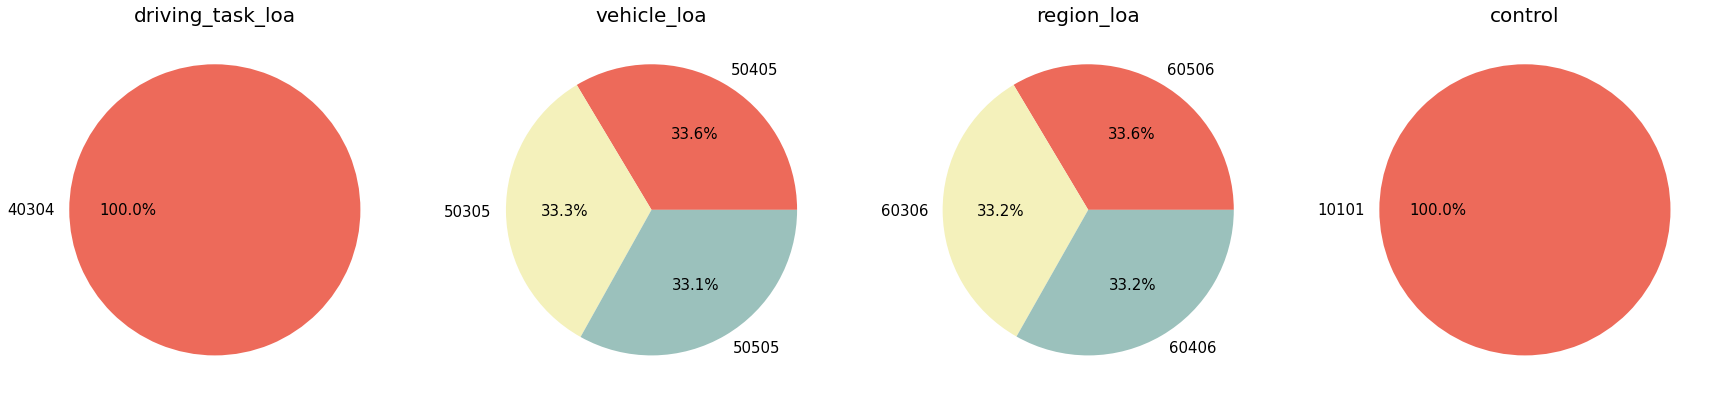

In [73]:
a1 = logs_with_resource[logs_with_resource.driving_task_loa==40204]
a1 = logs_with_resource[logs_with_resource.vehicle_loa==50205]
a1 = logs_with_resource

fontdict_title = {'fontsize': 20, 'fontname': 'Times New Roman'}
fontdict_labels = {'fontsize': 15, 'fontname': 'Times New Roman'}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title("driving_task_loa", fontdict=fontdict_title)
labels_ = list(a1.driving_task_loa.value_counts().index)
data_ = list(a1.driving_task_loa.value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-2
ax2.set_title("vehicle_loa", fontdict=fontdict_title)
labels_ = list(a1.vehicle_loa.value_counts().index)
data_ = list(a1.vehicle_loa.value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-3
ax3.set_title("region_loa", fontdict=fontdict_title)
labels_ = list(a1.region_loa.value_counts().index)
data_ = list(a1.region_loa.value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-4
ax4.set_title("control", fontdict=fontdict_title)
labels_ = list(a1.control.value_counts().index)
data_ = list(a1.control.value_counts())
ax4.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

plt.show()

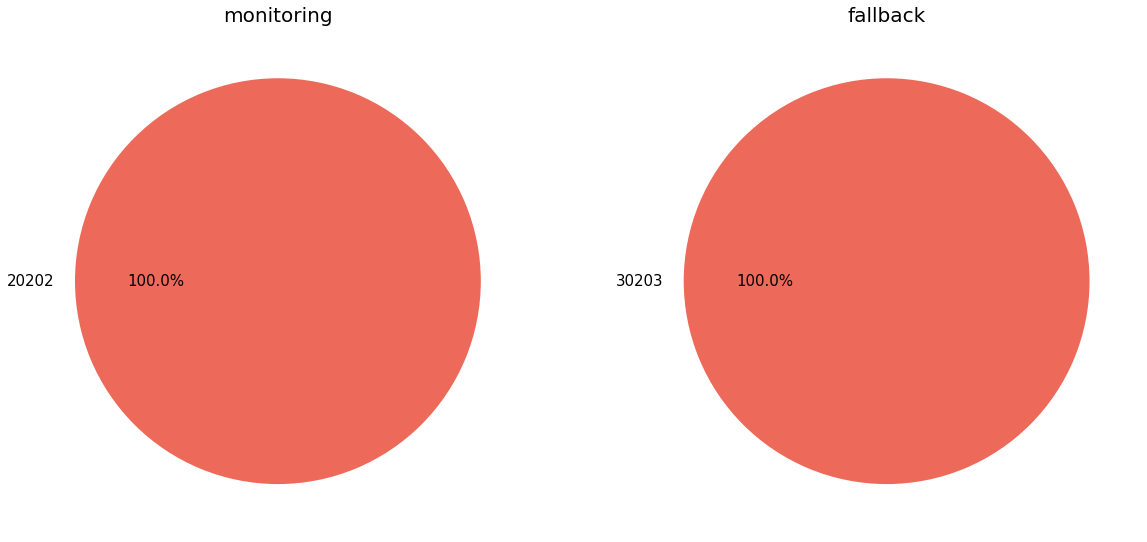

In [66]:
fontdict_title = {'fontsize': 20, 'fontname': 'Times New Roman'}
fontdict_labels = {'fontsize': 15, 'fontname': 'Times New Roman'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,30))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title("monitoring", fontdict=fontdict_title)
labels_ = list(a1.monitoring.value_counts().index)
data_ = list(a1.monitoring.value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%', textprops=fontdict_labels)

# AX-2
ax2.set_title("fallback", fontdict=fontdict_title)
labels_ = list(a1.fallback.value_counts().index)
data_ = list(a1.fallback.value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%', textprops=fontdict_labels)

plt.show()

#### Mediumn communities

In [23]:
counter_rules = 0
umbral_podado = 0.2
for comm in med_comms:
    resorces_coms = podar_recursos_new(comm[1], gb, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]],
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)            

Reglas generadas: 5


#### Big communities

In [20]:
counter_rules = 0
umbral_podado = 0.2
umbral_rec_sig = 0.5

for comm in big_comms:
    resorces_coms = podar_recursos_new(comm[1], gb, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:

        # Obtención de recursos significativos
        recursos_significativos = get_recursos_significativos(comm[1], gb, umbral_rec_sig)

        if len(recursos_significativos) > 0: # Si hay elementos
            for rec in recursos_significativos:
                regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.
                for attr in rsrc_attr: # Se agrega la regla con atr de recurso
                    logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==rec].iloc[0]
                    regla_i[1].append([attr, logs_with_resource[attr]])

                # Usuarios en la comunidad
                users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
                df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
                df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
                
                # Obtener regla apriori
                regla_atr_usuario = apriori_in_resources_4(
                    data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
                    recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
                
                regla_i[1] = regla_i[1] + regla_atr_usuario
                list_rules.append(regla_i)
                nuevas_reglas.append(regla_i[1])
                counter_rules += 1

        resto_coms = list(set(resorces_coms) - set(recursos_significativos))

        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(resto_coms)]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        #print(df_resources)
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        #print(regla_atr_recurso)
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)            

KeyboardInterrupt: 

In [24]:
counter_rules = 0
umbral_podado = 0.2
umbral_rec_sig = 0.5

for comm in big_comms:
    resorces_coms = podar_recursos_new(comm[1], gb, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:

        # Obtención de recursos significativos
        recursos_significativos = get_recursos_significativos2(comm[1], gb, umbral_rec_sig)

    
        for rec in recursos_significativos:
            regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.
            for attr in rsrc_attr: # Se agrega la regla con atr de recurso
                logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==rec].iloc[0]
                regla_i[1].append([attr, logs_with_resource[attr]])

            # Usuarios en la comunidad
            users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
            df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
            df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
            
            # Obtener regla apriori
            regla_atr_usuario = apriori_in_resources_4(
                data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
                recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
            
            regla_i[1] = regla_i[1] + regla_atr_usuario
            list_rules.append(regla_i)
            nuevas_reglas.append(regla_i[1])
            counter_rules += 1

        # resto_coms = list(set(resorces_coms) - set(recursos_significativos))

        # regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # # Solicitudes que incluyen el recurso
        # logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(resto_coms)]
        # logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        # df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # # Usuarios en la comunidad
        # users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        # df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        # df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # # Generar regla con los atributos de los recursos
        # #print(df_resources)
        # regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        # #print(regla_atr_recurso)
        # regla_atr_usuario = apriori_in_resources_4(
        #     data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
        #     recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # # Se agrega a la regla
        # regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # # print(regla_i)
        
        # list_rules.append(regla_i)
        # nuevas_reglas.append(regla_i[1])
        # counter_rules += 1

print("Reglas generadas:", counter_rules)            

Reglas generadas: 213


#### EXTRA

In [31]:
counter_rules = 0
for comm in big_comms:
    resorces_coms = comm[2] # Se extrae los recursos al que accede.
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]],
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])

        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)        

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)            

Reglas generadas: 5


In [25]:
len(list_rules)

229

In [27]:
new_rules_test = []
for i in list_rules:
    if not i[1] in new_rules_test:
        new_rules_test.append(i[1])
print("De ", len(list_rules), " - ", len(new_rules_test))
#new_rules_test

De  229  -  196


### TASK 2: Rule Network Model

#### Auxiliar

In [20]:
def evaluate_weight(rule_a, rule_b, umbral):
    """Retorna la arista entre dos reglas."""
    rule_atr_a = {}
    for item in rule_a:        
        rule_atr_a[item[0]] = item[1]

    rule_atr_b = {}
    for item in rule_b:
        rule_atr_b[item[0]] = item[1]

    conta_temp = 0
    for attr in rule_atr_a:
        if attr != "id_com":
            if attr in rule_atr_b:
                if rule_atr_a[attr] == rule_atr_b[attr]:
                    conta_temp += 1

    if conta_temp >= umbral:
        return conta_temp
    else:
        return -1

#### Main

In [35]:
rules_with_idx = {}
for idx, rule in enumerate(list_rules):
    rules_with_idx[idx] = rule

umbral_peso_grafo_reglas = 3
# Create the graph
lista_aristas = []
lista_posibles_no_estan = []
for idxA in range(len(list_rules)):
    flag_ = False
    for idxB in range(idxA+1, len(list_rules)):
        arista = evaluate_weight(rules_with_idx[idxA][1], 
            rules_with_idx[idxB][1], umbral_peso_grafo_reglas)
        if arista != -1:
            flag_ = True
            lista_aristas.append((idxA, idxB, arista))
    if flag_ == False:
        lista_posibles_no_estan.append(idxA)

Grules = nx.Graph()
Grules.add_weighted_edges_from(lista_aristas)
nodes_to_add = []
for i in lista_posibles_no_estan:
    if not i in Grules.nodes():
        nodes_to_add.append(i)
print("Nodos aislados:", len(nodes_to_add))
Grules.add_nodes_from(nodes_to_add)
print(nx.info(Grules))

Nodos aislados: 0
Name: 
Type: Graph
Number of nodes: 273
Number of edges: 10265
Average degree:  75.2015


In [43]:
GR = ig.Graph()
GR = GR.from_networkx(Grules)
GR.vs["name"] = GR.vs["_nx_name"]
del GR.vs["_nx_name"]
GR.summary()
GR.write_gml("output-files/rules-network-cav.gml")

## Evaluation

#### Auxiliar

In [22]:
def get_comm_for_user(diccionario_com_user, usuario):
    """Retorna el id de la comunidad al que pertenece el usuario."""
    for item in diccionario_com_user:
        if str(usuario)+".0" in diccionario_com_user[item]: # Si el usuario está en la comunidad
            return item
    return 0

def extraer_reglas_comunidad(lista_reglas, id_comunidad):
    """Retornal una lista de reglas de la comunidad."""
    to_ret = []
    for r in lista_reglas:
        if r[0][1] == id_comunidad: # Si es una regla que cumple con la comunidad
            to_ret.append(r)
    return to_ret

def extraer_reglas_comunidad_list(lista_reglas, list_id_comunidad):
    """Retornal una lista de reglas de la comunidad."""
    to_ret = []
    for r in lista_reglas:
        if r[0][1] in list_id_comunidad: # Si es una regla que cumple con la comunidad
            to_ret.append(r)
    return to_ret

def convert_to_list(dictionario_):
    to_return = []
    for i in dictionario_:
        to_return.append(i[0])
    return to_return

def compute_wsc(policy):
    return sum([len(rule) for rule in policy])

def evaluate_weight(rule_a, rule_b, umbral):
    """Retorna la arista entre dos reglas."""
    rule_atr_a = {}
    for item in rule_a:        
        rule_atr_a[item[0]] = item[1]

    rule_atr_b = {}
    for item in rule_b:
        rule_atr_b[item[0]] = item[1]

    conta_temp = 0
    for attr in rule_atr_a:
        if attr != "id_com":
            if attr in rule_atr_b:
                if rule_atr_a[attr] == rule_atr_b[attr]:
                    conta_temp += 1

    if conta_temp >= umbral:
        return conta_temp
    else:
        return -1

def get_rule_id(set_rules, dict_wiith_idx):
    """Retorna el id de las reglas para verlo en el grafo."""
    list_idx_ret =[]
    key_list = list(dict_wiith_idx.keys())
    val_list = list(dict_wiith_idx.values())
    for i in set_rules:
        position = val_list.index(i)
        list_idx_ret.append(key_list[position])
    return list_idx_ret

def get_neighbors_rules(list_rule_idx, rule_graph, dict_wiith_idx):
    """Retorna el idx de las reglas vecinas."""
    list_id_vecinos = []
    for idx in list_rule_idx: # Por cada regla
        # Se busca su vecino en el grafo
        for i in rule_graph.neighbors(idx):
            list_id_vecinos.append(i)

    list_id_vecinos = list_id_vecinos + list_rule_idx
    list_to_ret = []
    #print(list_id_vecinos)
    for idx in list_id_vecinos:
        list_to_ret.append(dict_wiith_idx[idx])
    return list_to_ret

def calculate_k_i(node):
    sum_to_ret = 0
    for i in node.all_edges():
        sum_to_ret += i["weight"]
    return sum_to_ret

def calculate_k_i_in(node, comm, graph_):
    # Sacar los vecinos del nodo
    vecinos_node = node.neighbors()

    # Ver cuales están en la comunidad
    id_com_ = comm.vs()[0]["comid"] # Id de la comunidad (se busca en primer nodo)

    # Se hace la intersección
    inter_vertex = []
    for veci in vecinos_node:
        if veci["comid"] == id_com_:
            inter_vertex.append(veci)

    # Se busca su peso
    kiin = 0
    for veci in inter_vertex:
        id_edge = graph_.get_eid(node, veci, directed=False)
        kiin += graph_.es()[id_edge]["weight"]
    
    return kiin*2

def calculate_sum_tot(comm, graph_):
    sum_tot = 0
    for i in comm.vs():
        id_label = i["name"]
        
        node = graph_.vs.find(name_eq = id_label)
        #print(node.all_edges())
        #print([i["weight"] for i in node.all_edges()])
        sum_tot += sum([i["weight"] for i in node.all_edges()])
    return sum_tot

def modularity_evaluate(node, comm, graph_):
    """Return the modularity value adding the node in the comm."""    
    sum_tot = calculate_sum_tot(comm, graph_)
    #print(sum_tot)
    sum_in = sum(comm.es()["weight"])*2 
    #print(sum_in)
    k_i_in = calculate_k_i_in(node, comm, graph_)
    #print(k_i_in)
    k_i = calculate_k_i(node)
    #print(k_i)
    m = graph_.ecount()
    #print(m)
    part_a = ((sum_in + 2*k_i_in) / (2*m) ) - ((sum_tot+k_i)/(2*m)*(sum_tot+k_i)/(2*m))
    part_b = (sum_in/(2*m)) - ((sum_tot/(2*m))*(sum_tot/(2*m))) - ((k_i/(2*m))*(k_i/(2*m)))
    return part_a - part_b

def add_new_user_node(user, resource, graph_, data):
    """Add new vertex in the graph based on share resource."""
    # Se extraen los usuarios que tienen el mismo recurso de acceso
    users_same_resource = data[data["RESID"]==resource].drop_duplicates()["USRID"].to_list()
    graph_.add_vertex(graph_.vcount()) # Se agrega el vértice en el grafo
    graph_.vs()[graph_.vcount()-1]["name"] = user # Agregar atributo lable
    user_obj = graph_.vs()[graph_.vcount()-1]
    #print(users_same_resource)
    for usr in users_same_resource:
        x = graph_.vs.find(name_eq=str(usr)+".0")    
        graph_.add_edges([(x, user_obj)])
        graph_.es()[-1]["weight"] = 1
    #print("Done!")

def add_new_user_node_2(user, resource, graph_, data):
    """Add new vertex in the graph based on share resource."""
    # Se extraen los usuarios que tienen el mismo recurso de acceso
    users_same_resource = set(data[data["RESID"]==resource].drop_duplicates()["USRID"].to_list())
    #print(users_same_resource)
    usuaris_grafo = set([int(float(i)) for i in graph_.vs()["name"]])
    users_same_resource = list(users_same_resource.intersection(usuaris_grafo))
    #print(users_same_resource)
    graph_.add_vertex(graph_.vcount()) # Se agrega el vértice en el grafo
    graph_.vs()[graph_.vcount()-1]["name"] = user # Agregar atributo lable
    user_obj = graph_.vs()[graph_.vcount()-1]
    #print(users_same_resource)
    for usr in users_same_resource:
        x = graph_.vs.find(name_eq=usr)    
        graph_.add_edges([(x, user_obj)])
        graph_.es()[-1]["weight"] = 1

def get_comunidades_vecinas(nodo, graph_):
    """Return ids communities neighboors."""
    vecinos_nodo = nodo.neighbors()
    lista_to_ret = []
    for vecino in vecinos_nodo:
        if not vecino["comid"] in lista_to_ret:
            lista_to_ret.append(vecino["comid"])
    return lista_to_ret

def obtener_reglas_comundiad(id_com, reglas):
    """Retorna las reglas con el identificador de comunidad"""
    list_to_ret = []
    for i in reglas:
        if i[0][1] == id_com:
            list_to_ret.append(i)
    return list_to_ret


#### Main

In [28]:
copy_g_proj = g_proj_B.copy() # Copia del grafo

temp_list = []

# Se agrega su id de comunidad
for node in copy_g_proj.vs():
    for i in dict_total_coms: 
        #print(node["name"])       
        if node["name"] in dict_total_coms[i][0].vs()["name"]:
            #print(i)
            node["comid"] = i

print(copy_g_proj.summary())

IGRAPH UNW- 5303 3512510 -- 
+ attr: cluster (v), comid (v), control (v), fallback (v), monitoring (v), name (v), traffic_congestion (v), visibility (v), weather (v), weight (e)


#### FN

In [103]:
# To create the dictionary with all resources.
all_resources = list(positive_cav_train.RESID.drop_duplicates())

dict_resrs_user = {}
for resrc in all_resources:
    dict_resrs_user[resrc] = list(positive_cav_train[positive_cav_train.RESID
        ==12202].USRID.drop_duplicates())
dict_resrs_user


{14202: [2755101,
  1000101,
  2210101,
  4405101,
  95101,
  2450101,
  2250101,
  1790101,
  5750101,
  250101,
  810101,
  6440101,
  5805101,
  3195101,
  370101,
  4115101,
  490101,
  3240101,
  2780101,
  1460101,
  2535101,
  1980101,
  6210101,
  955101,
  1335101,
  1445101,
  6400101,
  4430101,
  1925101,
  1915101,
  3470101,
  4065101,
  210101,
  2705101,
  4845101,
  1030101,
  6565101,
  6080101,
  1820101,
  2270101,
  4980101,
  5800101,
  1440101,
  3590101,
  2380101,
  6150101,
  3080101,
  860101,
  6410101,
  5890101,
  4650101,
  4555101,
  3505101,
  5900101,
  5885101,
  6635101,
  1580101,
  4260101,
  5965101,
  2710101,
  875101,
  190101,
  1550101,
  6050101,
  3655101,
  70101,
  1155101,
  380101,
  5780101,
  4015101,
  4750101,
  5540101,
  2990101,
  4365101,
  2965101,
  440101,
  185101,
  4725101,
  215101,
  6530101,
  1890101,
  5535101,
  610101,
  4445101,
  455101,
  4025101,
  6380101,
  3895101,
  5135101,
  2580101,
  6260101,
  5350101,


In [124]:
# In this cell, I write an efficient code to evaluate an access request to the
# Rule Network

def user_exist(user, user_network):
    """
    Return True if a user exist in the user network.

    Parameters
    ----------
    user : int

    user_network : igraph
        User network.

    Returns
    -------
    bool
        Returns True if the user exist in the user network. False in otherwise.
    """
    return True if user in user_network.vs()["name"] else False

def extract_id_comm(user, user_network):
    """
    Return the ID of the community that the user belongs it.

    Parameters
    ----------
    user : int

    user_network : igraph
        User network.

    Returns
    -------
    string
        Returns the ID of the community.
    """
    return user_network.vs.find(name=user)["comid"]

def add_node_to_network(user, resource, user_network, dict_resources):
    """
    Add a new user node to the user network.

    Parameters
    ----------
    user : int

    resource : int

    user_network : igraph
        User network.

    data_ : DataFrame pandas
        Train dataframe.
    """
    # Extract all user that accessed to the resource
    users_from_res = dict_resources[resource]

    # Create the user_node
    user_network.add_vertex(user_network.vcount()) # Se crea con el último ID.
    user_network.vs()[-1]["name"] = user # Agregar atributo de nombre.

    # Extract all igraph ID from from all users_from_res
    list_graphid_user = []
    for usr_idx in users_from_res:
        # Get the index of the igraoh id
        list_graphid_user.append( (user_network.vs()[-1].index, 
            copy_g_proj.vs.find(name=usr_idx).index) )
        
    # Create an edge with the new user node to all users_from_res
    user_network.add_edges(list_graphid_user)

def add_node_to_community(user, user_network):
    """
    Add the new user node to a communtiy more frequent between its neighbors.

    Parameters
    ----------
    user : int

    resource : int

    user_network : igraph
        User network.

    data_ : DataFrame pandas
        Train dataframe.
    """
    # User node object
    user_node = user_network.vs.find(name=user)
    #print(user_node)
    # Get its neighbors
    user_neighbors = user_node.neighbors()
    #print(user_neighbors)
    # Get all communities from the neightborhood
    all_communities = []
    for neighbor in user_neighbors:
        all_communities.append(neighbor["comid"])

    # Get the id most repeated in the communities list
    id_comm_more_freq = max(set(all_communities), key = all_communities.count)
    print(id_comm_more_freq)
    # Add comid attribute to the new user node
    user_node["comid"] = id_comm_more_freq                


def decision(row, user_network, rule_list, rule_network):
    """
    Evaluate the new access requests compared to the rule network.
    """
    user_id = row["USRID"]
    res_id = row["RESID"]
    copy_g = copy_g_proj.copy()

    # Check if the user exist in the network
    if not user_exist(user=user_id, user_network=user_network):
        # Add the user to the network
        add_node_to_network(user=user_id, resource=res_id,
            user_network=user_network, dict_resources=dict_resrs_user)
        
        # Add the user to one communtiy
        add_node_to_community(user=user_id, user_network=user_network)
    
    # Extract the id its community
    id_comm = extract_id_comm(user=user_id, user_network=user_network)

    # Get rules by id of the Community    
    list_of_rules = []
    for i in rule_list:
        if i[0][1] == id_comm:
            list_of_rules.append(i)
    
    
    # Get all neighbors of the selected rule
    list_rules_idx = get_rule_id(list_of_rules, rules_with_idx)


    # Compare the subset of the rule with the access request.

In [ ]:
rules_with_idx

{0: [['id_com', '0'],
  [['driving_task_loa', 40204],
   ['vehicle_loa', 50205],
   ['monitoring', 20202],
   ['fallback', 30203]]],
 1: [['id_com', '1'],
  [['driving_task_loa', 40204],
   ['vehicle_loa', 50305],
   ['control', 10101],
   ['fallback', 30203]]],
 2: [['id_com', '2'],
  [['driving_task_loa', 40204],
   ['vehicle_loa', 50205],
   ['control', 10101],
   ['monitoring', 20202],
   ['fallback', 30203]]],
 3: [['id_com', '3'],
  [['driving_task_loa', 40204],
   ['vehicle_loa', 50305],
   ['control', 10101],
   ['monitoring', 20202]]],
 4: [['id_com', '4'],
  [['driving_task_loa', 40204],
   ['vehicle_loa', 50305],
   ['control', 10101],
   ['monitoring', 20202],
   ['fallback', 30203]]],
 5: [['id_com', '16'],
  [['driving_task_loa', 40304],
   ['region_loa', 60506],
   ['control', 10101],
   ['monitoring', 20102]]],
 6: [['id_com', '17'],
  [['driving_task_loa', 40304],
   ['region_loa', 60506],
   ['control', 10101],
   ['fallback', 30203]]],
 7: [['id_com', '18'],
  [['dri

In [46]:
false_neg  = []
for i,row in positive_cav_train[:1].iterrows():
#for i, row in pos_test.iterrows():
    print(row)
    user_id = row["USRID"]
    res_id = row["RESID"]

    # Identificación de la comunidad
    copy_g = copy_g_proj.copy()
    add_new_user_node_2(user_id, res_id, copy_g, positive_cav_train) # Se agrega el nodo a la red
    node_user = copy_g.vs[-1] # Node de usuario
    
    # Identificar a las comunidades vecinas
    coms_vecinas = get_comunidades_vecinas(node_user, copy_g)
    
    # Probar la modularidad máxima
    max_mod = 0
    com_max = None
    for id_com in coms_vecinas:
        comunidad = copy_g.vs.select(comid_eq=id_com)
        comunidad = copy_g.subgraph(comunidad)
        temp_mod = modularity_evaluate(node_user, comunidad, copy_g)
        if temp_mod > max_mod:
            max_mod = temp_mod
            com_max = id_com
        # print("Mod:", temp_mod, " \t\t Comunidad:", id_com)
    print(" --- MAX MOD:", max_mod, "  --- COM:", com_max)

    list_coms_user = obtener_reglas_comundiad(com_max, list_rules)
    print(list_coms_user)
    list_rules_idx = get_rule_id(list_coms_user, rules_with_idx)
    print(list_rules_idx)
    list_coms_user = get_neighbors_rules(list_rules_idx, Grules, rules_with_idx)
    print(len(list_coms_user))

    # Evaluación
    denies_count = 0
    temp_rules_n = 0
    for rule in list_coms_user:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule[1]):
            # print(idx_r, attr_val)                                    
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count == len(list_coms_user):
        false_neg.append(row)
        print("FP-2")
    else:
        print("ENtra PAPA")

control                  10101
monitoring               20202
fallback                 30203
weather                      6
visibility                   0
traffic_congestion           0
driving_task_loa         40204
vehicle_loa              50405
region_loa               60406
USRID                   332101
RESID                    14202
result                approved
Name: 13642, dtype: object


KeyboardInterrupt: 

In [29]:
false_neg  = []
for i,row in positive_cav_train.iterrows():
#for i, row in pos_test.iterrows():
    #print(row)
    user_id = row["USRID"]
    res_id = row["RESID"]    

    # Evaluación
    denies_count = 0
    temp_rules_n = 0
    for rule in new_rules_test:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule):
            # print(idx_r, attr_val)                                    
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count == len(new_rules_test):
        false_neg.append(row)
        #print("FP-2")
    #else:
        #print("ENtra PAPA")

In [30]:
FN = len(false_neg)
print("Tasa FN: {:.2f}".format((FN/ len(positive_cav_train))*100))
print("FN: ", FN, " de ", len(positive_cav_train))

Tasa FN: 35.20
FN:  31764  de  90251


#### FP

In [47]:
false_pos  = []
for i,row in negative_cav_train[:50].iterrows():
#for i, row in pos_test.iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]

    # Identificación de la comunidad
    copy_g = copy_g_proj.copy()
    add_new_user_node_2(user_id, res_id, copy_g, negative_cav_train) # Se agrega el nodo a la red
    node_user = copy_g.vs[-1] # Node de usuario
    
    # Identificar a las comunidades vecinas
    coms_vecinas = get_comunidades_vecinas(node_user, copy_g)
    
    # Probar la modularidad máxima
    max_mod = 0
    com_max = None
    for id_com in coms_vecinas:
        comunidad = copy_g.vs.select(comid_eq=id_com)
        comunidad = copy_g.subgraph(comunidad)
        temp_mod = modularity_evaluate(node_user, comunidad, copy_g)
        if temp_mod > max_mod:
            max_mod = temp_mod
            com_max = id_com
        # print("Mod:", temp_mod, " \t\t Comunidad:", id_com)
    #print(" --- MAX MOD:", max_mod, "  --- COM:", com_max)

    list_coms_user = obtener_reglas_comundiad(com_max, list_rules)
    #print(list_coms_user)
    list_rules_idx = get_rule_id(list_coms_user, rules_with_idx)
    #print(list_rules_idx)
    list_coms_user = get_neighbors_rules(list_rules_idx, Grules, rules_with_idx)

    # Evaluación
    denies_count = 0
    temp_rules_n = 0
    for rule in list_coms_user:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule[1]):
            # print(idx_r, attr_val)                                
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count < len(list_coms_user):
        false_pos.append(row)
        #print("FP-2")    
    #else:
    #    print("ENtra PAPA")
    

NameError: name 'copy_g_proj' is not defined

In [31]:
false_pos  = []
for i,row in negative_cav_train.iterrows():
#for i, row in pos_test.iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]    

    # Evaluación
    denies_count = 0
    temp_rules_n = 0
    for rule in new_rules_test:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule):
            # print(idx_r, attr_val)                                
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count < len(new_rules_test):
        false_pos.append(row)
        #print("FP-2")    
    #else:
    #    print("ENtra PAPA")
    

In [32]:
FP = len(false_pos)
print("Tasa FP: {:.2f}".format((FP/ len(negative_cav_train))*100))
print("FN: ", FP, " de ", len(negative_cav_train))

Tasa FP: 15.33
FN:  14794  de  96484


#### F-Score

In [33]:

TP = len(positive_cav_train) - FN
#TP = 50 - FN
TN = len(negative_cav_train) - FP
#TN = 50 - FP

precision = TP / (TP + FP)

recall = TP / (TP + FN)

fscore = 2*(precision*recall)/(precision+recall)

print("FN:", FN, " - {:.2f}".format((FN/len(positive_cav_train))*100))
#print("FN:", FN, " - {:.2f}".format((FN/50)*100))
print("FP:", FP, " - {:.2f}".format((FP/len(negative_cav_train))*100))
#print("FP:", FP, " - {:.2f}".format((FP/50)*100))
print("Precision:", precision)
print("Recall:", recall)
print("F-score", fscore)

def compute_wsc(policy):
    return sum([len(rule[1]) for rule in policy])

print("# Rules:", len(new_rules_test))
print("WSC:", compute_wsc(new_rules_test))

FN: 31764  - 35.20
FP: 14794  - 15.33
Precision: 0.7981195671456448
Recall: 0.6480482210723427
F-score 0.7152973118411076
# Rules: 196
WSC: 392


## Policy Refinement

### TASK 1: False Negative Network Modelling

In [34]:
list_new_edges = []
false_negs_df = pd.DataFrame(false_neg)
for idx_usr, idx_rsr in false_negs_df[["USRID","RESID"]].values:    
    list_new_edges.append((int(idx_usr), int(idx_rsr)))
new_g = nx.Graph()
new_g.add_edges_from(list_new_edges)

#print(list_new_edges)

new_g = ig.Graph.from_networkx(new_g)
new_g.vs["name"] = new_g.vs["_nx_name"]
del new_g.vs["_nx_name"]

# Identificar los grafo usuario y los grafo recurso.
list_temp = list(false_negs_df.USRID)
list_type = []
for vertex in new_g.vs():
    if vertex["name"] in list_temp:
        list_type.append(0)
    else:
        list_type.append(1)

new_g.vs["typen"] = list_type
#g = ig.Graph(list_edges)
# nodes_to_remove = g.vs.select(_degree=0) # Node with 0 degree (isolated)
# g.delete_vertices(nodes_to_remove)
print(new_g.summary())
print("User nodes: ", len(new_g.vs.select(typen=0)))
print("Res nodes: ", len(new_g.vs.select(typen=1)))

print("Is bipartite? ", new_g.is_bipartite())

IGRAPH UN-- 3951 31764 -- 
+ attr: name (v), typen (v)
User nodes:  3921
Res nodes:  30
Is bipartite?  True


### TASK 2: FN User Network

In [35]:
g_proj_B_new = graph_projectionB(new_g)
print(nx.info(g_proj_B_new)) # Networkx graph
# Writing the gml
file_name = "output-files/proj-cav-RF.gml"
nx.write_gml(g_proj_B_new, file_name)
g_proj_B_new = ig.read(file_name)
g_proj_B_new.vs["name"] = g_proj_B_new.vs["label"]
print(g_proj_B_new.summary())

# Agregar atributos al grafo bipartito
for attr in user_attr:    
    list_temp = []
    for node in g_proj_B_new.vs():                
        id_name = float(node["label"])
        temp = pd.DataFrame(false_negs_df[false_negs_df.USRID==id_name])            
        temp = temp[attr].drop_duplicates()            
        temp = temp.values[0]
        list_temp.append(temp)            
    g_proj_B_new.vs[attr] = list_temp

g_proj_B_new.write_gml(file_name)
print(g_proj_B_new.summary())

Name: 
Type: Graph
Number of nodes: 3921
Number of edges: 2516288
Average degree: 1283.4930
IGRAPH UNW- 3921 2516288 -- 
+ attr: id (v), label (v), name (v), weight (e)
IGRAPH UNW- 3921 2516288 -- 
+ attr: control (v), fallback (v), id (v), label (v), monitoring (v), name (v), traffic_congestion (v), visibility (v), weather (v), weight (e)


### TASK 3: Community Detection

In [36]:
partition = g_proj_B_new.community_multilevel(weights=g_proj_B_new.es()["weight"])
print("Modularity C %.4f" % partition.modularity)
# Add cluster attribute to nodes
g_proj_B_new.vs["cluster"] = partition.membership
print(g_proj_B_new.summary())

Modularity C 0.6665
IGRAPH UNW- 3921 2516288 -- 
+ attr: cluster (v), control (v), fallback (v), id (v), label (v), monitoring (v), name (v), traffic_congestion (v), visibility (v), weather (v), weight (e)


#### TASK 3.1: Community classification

In [37]:
# Se obtienen las comunidades y sub-comunidades
g = g_proj_B_new

density_threshold = 0.5

n_coms = len(set(g.vs["cluster"]))
count_n_coms = 0 # Contador de número de comunidades detectadas
# Diccionario con las comunidades. Id de la comunidad como key y una lista 
# como value {01: [subgrafo, recursos_list]}
dict_total_coms2 = {} 

for idx_comm in range(n_coms): # Recorrer cada comunidad en la red
    subgraph_nodes = g.vs.select(cluster=idx_comm) # Sacamos los nodos con el cluster
    comm_subgraph = subgraph_nodes.subgraph() # Objeto de subgrafo

    # Verificar si la densidad es baja: Si es baja se puede clasificar
    #if comm_subgraph.density() < density_threshold:

    # Se realiza nuevamente una partición
    new_partition = comm_subgraph.community_multilevel(
        weights =comm_subgraph.es["weight"] )        

    for sub_com in new_partition.subgraphs(): # Se recorre cada nueva sub comunidad
        # Usuarios en la comunidad
        user_set_comm = sub_com.vs()["label"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, gb)            
        dict_total_coms2[str(count_n_coms)+"666"] = [sub_com, n_res]
        count_n_coms += 1
    #else:
    #    user_set_comm = comm_subgraph.vs()["label"]   
    #    # Recursos en la comunidad
    #    n_res = num_recursos(user_set_comm, gb)            
    #    dict_total_coms2[str(count_n_coms)+"666"] = [comm_subgraph, n_res]
    #    count_n_coms += 1

print("# de Comunidades: ", len(dict_total_coms2))

# de Comunidades:  14


In [38]:
# Obtener el máximo valor de recursos en el total de comunidades
n_res_in_comms = [len(i[1]) for i in dict_total_coms2.values()]
max_n_res = max(n_res_in_comms)
print("Comunidad con # mayor recursos", max_n_res)

# Umbrales para la clasificación de comunidades
big_threshold = int(0.50 * max_n_res)
med_threshold = int(0.25 * max_n_res)
print("Big Threshold: ", big_threshold, " \t\t Med Threshold", med_threshold)

Comunidad con # mayor recursos 25
Big Threshold:  12  		 Med Threshold 6


In [39]:
big_comms = [] # Almacenar las comunidades grandes
med_comms = [] # Almacenar las comunidades medianas
sma_comms = [] # Almacenar las comunidades pequeñas

for idx_com, com in enumerate(dict_total_coms2.values()):
    #print(idx_com, com)
    if len(com[1]) > big_threshold: # Es comunidad grande
        big_comms.append([list(dict_total_coms2.keys())[idx_com]]+com)
    elif len(com[1]) > med_threshold: # Es comunidad mediana
        med_comms.append([list(dict_total_coms2.keys())[idx_com]]+com)
    else:
        sma_comms.append([list(dict_total_coms2.keys())[idx_com]]+com)

print("# Comunidades:",len(big_comms)+len(med_comms)+len(sma_comms), "==", len(dict_total_coms2))
print("Big Comms:", len(big_comms))
print("Med Comms:", len(med_comms))
print("Sma Comms:", len(sma_comms))

# Comunidades: 14 == 14
Big Comms: 11
Med Comms: 3
Sma Comms: 0


### TASK 4: Rule inference

In [63]:
dict_ress_coms_2 = {} # Diccionario de recursos
list_rules_2 = [] # Lista de reglas
dict_res_in_coms_2 = {} # Diccionarios de recursos en comunidad

#### TASK 4.1: Small Comms.

In [64]:
counter_rules = 0
for comm in sma_comms:
    resorces_coms = comm[2] # Se extrae los recursos al que accede.
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        #print(regla_atr_recurso)        
        #print(df_resources.vehicle_loa.drop_duplicates())      
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  
        #print(df_users_in_comm.fallback.drop_duplicates())      

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)

Reglas generadas: 0


#### Task 4.2: Medium Comms.

In [65]:
counter_rules = 0
umbral_podado = 0.2
for comm in med_comms:
    resorces_coms = podar_recursos_new(comm[1], new_g, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)

Reglas generadas: 3


#### TASK 4.3: Big Comms.

In [43]:
counter_rules = 0
umbral_podado = 0.2
umbral_rec_sig = 0.5

for comm in big_comms:
    resorces_coms = podar_recursos_new(comm[1], new_g, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        #print("Check")
        counter_rules += 1
    else:

        # Obtención de recursos significativos
        recursos_significativos = get_recursos_significativos(comm[1], new_g, umbral_rec_sig)

        if len(recursos_significativos) > 0: # Si hay elementos
            for rec in recursos_significativos:
                regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.
                for attr in rsrc_attr: # Se agrega la regla con atr de recurso
                    logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==rec].iloc[0]
                    regla_i[1].append([attr, logs_with_resource[attr]])

                # Usuarios en la comunidad
                users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
                df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
                df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
                
                # Obtener regla apriori
                regla_atr_usuario = apriori_in_resources_4(
                    data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
                    recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
                regla_i[1] = regla_i[1] + regla_atr_usuario
                list_rules_2.append(regla_i)
                nuevas_reglas.append(regla_i[1])
                counter_rules += 1

        resto_coms = list(set(resorces_coms) - set(recursos_significativos))

        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(resto_coms)]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        print("Check")
        counter_rules += 1

print("Reglas generadas:", counter_rules)            

KeyboardInterrupt: 

In [47]:
counter_rules = 0
umbral_podado = 0.2
for comm in big_comms:
    resorces_coms = podar_recursos_new(comm[1], new_g, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # Solicitudes que incluyen el recurso
        logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(comm[2])]
        logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Generar regla con los atributos de los recursos
        regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # Se agrega a la regla
        regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # print(regla_i)
        
        list_rules_2.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1

print("Reglas generadas:", counter_rules)

Reglas generadas: 11


In [66]:
counter_rules = 0
umbral_podado = 0.2
umbral_rec_sig = 0.5

for comm in big_comms:
    resorces_coms = podar_recursos_new(comm[1], gb, umbral_podado)    
    if len(resorces_coms) == 1: # Si sólo hay un recurso
        # Se extraen los atributos del único recurso
        regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==comm[2][0]].iloc[0]

        for attr in rsrc_attr: # Se agrega la regla con atr de recurso
            regla_i[1].append([attr, logs_with_resource[attr]])
        
        # Usuarios en la comunidad
        users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # Obtener regla apriori
        regla_atr_usuario = apriori_in_resources_4(
            data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
            recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
        regla_i[1] = regla_i[1] + regla_atr_usuario

        list_rules.append(regla_i)
        nuevas_reglas.append(regla_i[1])
        counter_rules += 1
    else:

        # Obtención de recursos significativos
        recursos_significativos = get_recursos_significativos2(comm[1], gb, umbral_rec_sig)

    
        for rec in recursos_significativos:
            regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.
            for attr in rsrc_attr: # Se agrega la regla con atr de recurso
                logs_with_resource = positive_cav_train[positive_cav_train["RESID"]==rec].iloc[0]
                regla_i[1].append([attr, logs_with_resource[attr]])

            # Usuarios en la comunidad
            users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
            df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
            df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
            
            # Obtener regla apriori
            regla_atr_usuario = apriori_in_resources_4(
                data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
                recurso_atr=regla_i[1], reglas_ante=nuevas_reglas)  
            
            regla_i[1] = regla_i[1] + regla_atr_usuario
            list_rules.append(regla_i)
            nuevas_reglas.append(regla_i[1])
            counter_rules += 1

        # resto_coms = list(set(resorces_coms) - set(recursos_significativos))

        # regla_i = [ ["id_com", str(comm[0])], [] ] # Se comienza generando la regla.        
        
        # # Solicitudes que incluyen el recurso
        # logs_with_resource = positive_cav_train[positive_cav_train['RESID'].isin(resto_coms)]
        # logs_with_resource = logs_with_resource[rsrc_attr+["USRID","RESID"]].drop_duplicates()
        # df_resources = logs_with_resource[rsrc_attr+["RESID"]].drop_duplicates()
        
        # # Usuarios en la comunidad
        # users_in_sub_com = set([int(float(i)) for i in comm[1].vs()["name"]])
        # df_users_in_comm = positive_cav_train[positive_cav_train["USRID"].isin(users_in_sub_com)]
        # df_users_in_comm = df_users_in_comm[user_attr+["USRID"]].drop_duplicates()                    
        
        # # Generar regla con los atributos de los recursos
        # #print(df_resources)
        # regla_atr_recurso = apriori_in_resources_3(data_=df_resources[rsrc_attr]) 
        # #print(regla_atr_recurso)
        # regla_atr_usuario = apriori_in_resources_4(
        #     data_=df_users_in_comm[["control", "monitoring", "fallback"]], 
        #     recurso_atr=regla_atr_recurso, reglas_ante=nuevas_reglas)  

        # # Se agrega a la regla
        # regla_i[1] = regla_i[1] + regla_atr_recurso + regla_atr_usuario
        # # print(regla_i)
        
        # list_rules.append(regla_i)
        # nuevas_reglas.append(regla_i[1])
        # counter_rules += 1

print("Reglas generadas:", counter_rules)            

Reglas generadas: 207


#### TASK 4.4: Augmented Rule Network 

In [53]:
rules_with_idx = {}
total_rules = list_rules + list_rules_2
for idx, rule in enumerate(total_rules):
    rules_with_idx[idx] = rule

# Create the graph
lista_aristas = []
for idxA in range(len(total_rules)):
    for idxB in range(idxA, len(total_rules)):
        arista = evaluate_weight(rules_with_idx[idxA][1], rules_with_idx[idxB][1], 3)
        if arista != -1:
            lista_aristas.append((idxA, idxB, arista))

Grules_new = nx.Graph()
Grules_new.add_weighted_edges_from(lista_aristas)

def obtener_reglas_comundiad(id_com, reglas):
    """Retorna las reglas con el identificador de comunidad"""
    list_to_ret = []
    for i in reglas:
        if i[0][1] == id_com:
            list_to_ret.append(i)
    return list_to_ret

In [69]:
rules_with_idx = {}
for idx, rule in enumerate(new_rules_test_2):
    rules_with_idx[idx] = rule

# Create the graph
lista_aristas = []
for idxA in range(len(new_rules_test_2)):
    for idxB in range(idxA, len(new_rules_test_2)):
        arista = evaluate_weight(rules_with_idx[idxA], rules_with_idx[idxB], 3)
        if arista != -1:
            lista_aristas.append((idxA, idxB, arista))

Grules_new = nx.Graph()
Grules_new.add_weighted_edges_from(lista_aristas)
print(nx.info(Grules_new))

def obtener_reglas_comundiad(id_com, reglas):
    """Retorna las reglas con el identificador de comunidad"""
    list_to_ret = []
    for i in reglas:
        if i[0][1] == id_com:
            list_to_ret.append(i)
    return list_to_ret

Name: 
Type: Graph
Number of nodes: 406
Number of edges: 17574
Average degree:  86.5714


In [71]:
len(new_rules_test_2)

406

In [70]:
for i in Grules_new.nodes:
    if i < 196:        
        Grules_new.nodes[i]["tipo"] = 0
    else:
        Grules_new.nodes[i]["tipo"] = 1
    Grules_new.nodes[i]["com"] = int(total_rules[i][0][1])
Grules_new.nodes.data()

Grules_new.remove_edges_from(nx.selfloop_edges(Grules_new))

nx.write_gml(Grules_new, "output-files/rule-network-2.gml")

In [72]:
print(nx.info(Grules_new))
print(Grules_new.nodes.data(True))

Name: 
Type: Graph
Number of nodes: 406
Number of edges: 17168
Average degree:  84.5714
[(0, {'tipo': 0, 'com': 0}), (1, {'tipo': 0, 'com': 1}), (2, {'tipo': 0, 'com': 2}), (3, {'tipo': 0, 'com': 3}), (199, {'tipo': 1, 'com': 10}), (202, {'tipo': 1, 'com': 10}), (205, {'tipo': 1, 'com': 10}), (211, {'tipo': 1, 'com': 10}), (213, {'tipo': 1, 'com': 10}), (220, {'tipo': 1, 'com': 10}), (221, {'tipo': 1, 'com': 10}), (222, {'tipo': 1, 'com': 10}), (223, {'tipo': 1, 'com': 10}), (224, {'tipo': 1, 'com': 10}), (225, {'tipo': 1, 'com': 10}), (226, {'tipo': 1, 'com': 10}), (228, {'tipo': 1, 'com': 10}), (229, {'tipo': 1, 'com': 666}), (231, {'tipo': 1, 'com': 666}), (232, {'tipo': 1, 'com': 666}), (233, {'tipo': 1, 'com': 666}), (235, {'tipo': 1, 'com': 666}), (236, {'tipo': 1, 'com': 666}), (238, {'tipo': 1, 'com': 666}), (239, {'tipo': 1, 'com': 666}), (240, {'tipo': 1, 'com': 666}), (241, {'tipo': 1, 'com': 666}), (243, {'tipo': 1, 'com': 666}), (244, {'tipo': 1, 'com': 1666}), (245, {'tip

In [74]:
copy_g_proj2 = copy_g_proj.copy() # Copia del grafo
modificaciones = 0

lista_comid = []
# Se agrega su id de comunidad
for node in copy_g_proj2.vs():
    bandera = True
    for i in dict_total_coms2:        
        if str(node["name"]) in dict_total_coms2[i][0].vs()["name"]:
            #print(i)
            modificaciones += 1
            lista_comid.append(i)
            bandera = False
    if bandera:
        lista_comid.append(node["comid"])
        
print("Usuarios modificar: ", modificaciones)
print("Tamano lista Comid: ", len(lista_comid))
copy_g_proj2.vs["comid"] = lista_comid
print(copy_g_proj2.summary())
print(copy_g_proj2.vs()[0])

Usuarios modificar:  25
Tamano lista Comid:  4817
IGRAPH UNW- 4817 706967 -- 
+ attr: cluster (v), comid (v), name (v), weight (e)
igraph.Vertex(<igraph.Graph object at 0x0000020847D5F408>, 0, {'name': 602101, 'cluster': 0, 'comid': '0'})


### TASK 5: Evaluation

In [189]:
a = []
for i in list_rules_2:
    if not i[1] in a:
        a.append(i[1])
print(len(a), len(list_rules_2))

5 17


In [53]:
len(nuevas_reglas)

254

In [67]:
new_rules_test_2 = []
total_rules = list_rules + list_rules_2
for i in nuevas_reglas:
    if not i in new_rules_test_2:
        new_rules_test_2.append(i)
print(len(new_rules_test_2), len(new_rules_test))
new_rules_test_2

406 196


[[['driving_task_loa', 40204],
  ['vehicle_loa', 50205],
  ['control', 10101],
  ['monitoring', 20202]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50205],
  ['control', 10101],
  ['monitoring', 20202],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50205],
  ['monitoring', 20202],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50205],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['region_loa', 60506],
  ['monitoring', 20102],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['vehicle_loa', 50305],
  ['monitoring', 20102],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['region_loa', 60506],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['regi

#### TASK 5.1: FN

In [75]:
false_neg2  = []
ver_pos = []
lista_reglas_add = []
for i,row in positive_cav_train[:100].iterrows():
#for i, row in pos_test.iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]

    # Identificación de la comunidad
    copy_g = copy_g_proj2.copy()
    #print(user_id, res_id)
    add_new_user_node_2(user_id, res_id, copy_g, positive_cav_train) # Se agrega el nodo a la red
    node_user = copy_g.vs[-1] # Node de usuario
    
    # Identificar a las comunidades vecinas
    coms_vecinas = get_comunidades_vecinas(node_user, copy_g)
    
    # Probar la modularidad máxima
    max_mod = 0
    com_max = None
    for id_com in coms_vecinas:
        comunidad = copy_g.vs.select(comid_eq=id_com)
        comunidad = copy_g.subgraph(comunidad)
        temp_mod = modularity_evaluate(node_user, comunidad, copy_g)
        if temp_mod > max_mod:
            max_mod = temp_mod
            com_max = id_com
        # print("Mod:", temp_mod, " \t\t Comunidad:", id_com)
    #print(" --- MAX MOD:", max_mod, "  --- COM:", com_max)

    list_coms_user = obtener_reglas_comundiad(com_max, total_rules)
    #print(list_coms_user)
    list_rules_idx = get_rule_id(list_coms_user, rules_with_idx)
    #print(list_rules_idx)
    list_coms_user = get_neighbors_rules(list_rules_idx, Grules_new, rules_with_idx)

    # Evaluación
    denies_count = 0    
    for rule in list_coms_user:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule[1]):
            # print(idx_r, attr_val)                                
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
        else:
            ver_pos.append(row)
            lista_reglas_add.append(rule[1])
            #print(row, rule)
            break
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count == len(list_coms_user):
        false_neg2.append(row)
        #print("FP-2")
    #else:
        #print("ENtra PAPA")

In [315]:
false_neg2  = []
ver_pos = []
lista_reglas_add = []
for i,row in positive_cav_test.iterrows():
#for i, row in pos_test.iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]    

    # Evaluación
    denies_count = 0    
    for rule in nuevas_reglas:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule):
            # print(idx_r, attr_val)                                
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
        else:
            ver_pos.append(row)
            lista_reglas_add.append(rule)
            #print(row, rule)
            break
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count == len(nuevas_reglas):
        false_neg2.append(row)
        #print("FP-2")
    #else:
        #print("ENtra PAPA")

In [316]:
FN = len(false_neg2)
print("Tasa FN: {:.2f}%".format((FN/ len(positive_cav_test))*100))
#print("Tasa FN: {:.2f}%".format((FN/ 100)*100))
print("FN: ", FN, " de ", len(positive_cav_test))

Tasa FN: 9.85%
FN:  2343  de  23795


#### TASK 5.2: FP

In [64]:
false_pos2  = []
for i,row in positive_cav_train[:100].iterrows():
#for i, row in pd.DataFrame(false_pos).iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]

    # Identificación de la comunidad
    copy_g = copy_g_proj2.copy()
    add_new_user_node_2(user_id, res_id, copy_g, positive_cav_train) # Se agrega el nodo a la red
    node_user = copy_g.vs[-1] # Node de usuario
    
    # Identificar a las comunidades vecinas
    coms_vecinas = get_comunidades_vecinas(node_user, copy_g)
    
    # Probar la modularidad máxima
    max_mod = 0
    com_max = None
    for id_com in coms_vecinas:
        comunidad = copy_g.vs.select(comid_eq=id_com)
        comunidad = copy_g.subgraph(comunidad)
        temp_mod = modularity_evaluate(node_user, comunidad, copy_g)
        if temp_mod > max_mod:
            max_mod = temp_mod
            com_max = id_com
        # print("Mod:", temp_mod, " \t\t Comunidad:", id_com)
    #print(" --- MAX MOD:", max_mod, "  --- COM:", com_max)

    list_coms_user = obtener_reglas_comundiad(com_max, total_rules)
    #print(list_coms_user)
    list_rules_idx = get_rule_id(list_coms_user, rules_with_idx)
    #print(list_rules_idx)
    list_coms_user = get_neighbors_rules(list_rules_idx, Grules_new, rules_with_idx)

    # Evaluación
    denies_count = 0    
    for rule in list_coms_user:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule[1]):
            # print(idx_r, attr_val)                                    
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count < len(list_coms_user):
        false_pos2.append(row)
        #print(row)
        #print(list_coms_user)
        #print("FP-2")    
    #else:
        #print("ENtra PAPA")
    

NameError: name 'copy_g_proj2' is not defined

In [317]:
false_pos2  = []
for i,row in negative_cav_test.iterrows():
#for i, row in pd.DataFrame(false_pos).iterrows():
    user_id = row["USRID"]
    res_id = row["RESID"]
    # Evaluación
    denies_count = 0    
    for rule in new_rules_test_2:                                      
        # En esta parte se evalua la regla completa
        res = True                        
        for idx_r, attr_val in enumerate(rule):
            # print(idx_r, attr_val)                                    
            if row[attr_val[0]] != attr_val[1]:                                
                #print("Fallo en -- Row:",row[attr_val[0]], " --- Reg:", attr_val[1], " --- DIFE:", attr_val)
                res = False
                break                                            
        if res == False:
            denies_count += 1                                
    #print("XXX-", denies_count, temp_rules_n, res)
    if denies_count < len(new_rules_test_2):
        false_pos2.append(row)
        #print(row)
        #print(list_coms_user)
        #print("FP-2")    
    #else:
        #print("ENtra PAPA")
    

In [318]:
FP = len(false_pos2)
#print("Tasa FP: {:.2f}%".format((FP/ len(df_train_k_neg))*100))
print("Tasa FP: {:.2f}%".format((FP/ len(negative_cav_test))*100))
#print("FN: ", FP, " de ", len(df_train_k_neg))
print("FN: ", FP, " de ", len(negative_cav_test))

Tasa FP: 10.90%
FN:  2628  de  24121


#### TASK 5.3: Quality

In [319]:
TP = len(positive_cav_test) - FN
TN = len(negative_cav_test) - FP

precision = TP / (TP + FP)

recall = TP / (TP + FN)

fscore = 2*(precision*recall)/(precision+recall)

print("FN:", FN, " - {:.2f}".format((FN/len(positive_cav_test))*100))
print("FP:", FP, " - {:.2f}".format((FP/len(negative_cav_test))*100))
print("Precision:", precision)
print("Recall:", recall)
print("F-score", fscore)

def compute_wsc(new_rules_test_2):
    return sum([len(rule) for rule in new_rules_test_2])

print("# Rules:", len(new_rules_test_2))
print("WSC:", compute_wsc(new_rules_test_2))


FN: 2343  - 9.85
FP: 2628  - 10.90
Precision: 0.8908637873754153
Recall: 0.9015339357007774
F-score 0.8961671018276762
# Rules: 395
WSC: 1963


In [320]:
new_rules_test_2

[[['driving_task_loa', 40304],
  ['region_loa', 60506],
  ['monitoring', 20102],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['region_loa', 60506],
  ['control', 10101],
  ['monitoring', 20102],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40304],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['monitoring', 20102]],
 [['driving_task_loa', 40304],
  ['region_loa', 60506],
  ['control', 10101],
  ['monitoring', 20102]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['monitoring', 20202],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50305],
  ['monitoring', 20202],
  ['fallback', 30203]],
 [['driving_task_loa', 40204],
  ['vehicle_loa', 50305],
  ['control', 10101],
  ['monitoring', 20202]],
 [['driving_ta